# Classifing Injury Code based on Occupational Injury Report

Every day, work-related injury records are generated. In order to alleviate the human effort expended with coding such records, the Centers for Disease Control and Prevention (CDC) National Institute for Occupational Safety and Health (NIOSH), in close partnership with the Laboratory for Innovation Science at Harvard (LISH), is interested in improving their NLP/ML model to automatically read injury records and classify them according to the Occupational Injury and Illness Classification System (OIICS).

https://www.topcoder.com/challenges/30103825

OIICS Coding Scheme Definitions: https://wwwn.cdc.gov/wisards/oiics/

## Load the Data

The input training file is a cvs file (with a header) with 4 columns (`text`, `sex`, `age`, and `event`) and 153956 observations.

1. `text`; This column describes the raw injury description text data.

2. `sex`; This is a categorical variable, describing the sex of the related person.

3. `age`; This is a positive integer variable, describing the age of the related person.

4. `event`; This is the target variable, specifying the OIICS label to be classified. There are 48 unique labels in total.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# Load data
data = pd.read_csv('train.csv')

In [3]:
# Examine head of df

data.head()

,text,sex,age,event
0,57YOM WITH CONTUSION TO FACE AFTER STRIKING IT...,1,57,62
1,A 45YOM FELL ON ARM WHILE WORKING HAD SLIPPED ...,1,45,42
2,58YOM WITH CERVICAL STRAIN BACK PAIN S P REST...,1,58,26
3,33 YOM LAC TO HAND FROM A RAZOR KNIFE,1,33,60
4,53YOM AT WORK IN A WAREHOUSE DOING UNSPECIFIED...,1,53,71


In [4]:
# Examine df info

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153956 entries, 0 to 153955
Data columns (total 4 columns):
text     153956 non-null object
sex      153956 non-null int64
age      153956 non-null int64
event    153956 non-null int64
dtypes: int64(3), object(1)
memory usage: 4.7+ MB


In [5]:
# Look at numerical data

data.describe()

,sex,age,event
count,153956.000000,153956.00000,153956.000000
mean,1.354361,38.28868,54.850808
std,0.478321,13.26070,18.526890
min,1.000000,0.00000,10.000000
25%,1.000000,27.00000,43.000000
50%,1.000000,37.00000,62.000000
75%,2.000000,48.00000,70.000000
max,2.000000,96.00000,99.000000


While there do not appear to be any null values, there are min values in the `age` column equal to 0. These are most likely placeholder values for unknown data and will need to be evaluated further. If the age of the injured person can not be determined from the `text`, these values will be imputed with the median value of the `age` column, 37 years old.

In [6]:
# Analyze placeholder values for age

zero_age = data.loc[data.age == 0]
zero_age

,text,sex,age,event
7323,UNK AGE FEMALE ACCIDENTALLY CUT SELF W DIRTY S...,2,0,55
17671,UNK AGE MALE IS A PARKING ATTENDANT AT WORK AN...,1,0,73
24760,UNK AGE MALE C O DOING HEAVY LIFTING AT WORK A...,1,0,71
26503,UNKNOWN AGE MALE WITH EXPOSURE TO CARBON DIOXI...,1,0,55
34429,UNID D MALE WAS THE DRIVER OF A TRACTOR TRAILE...,1,0,26
34890,UNID D MALE WAS COOKING A RETAURANT WHEN PRES...,1,0,32
41930,UNKNOWN AGE MALE WITH EXPOSURE TO CARBON DIOXI...,1,0,55
44621,UNK AGE MALE SUSTAINED AN ELECTRICAL SHOCK AND...,1,0,43
45835,UKN YOM WITH MULTIPLE TRAUMATIC INJURIES AFTER...,1,0,65
58278,UNKNOWN AGE MALE WITH EXPOSURE TO CARBON DIOXI...,1,0,55


Only instance 133289 has the age of the injured person in the text of the report. Thus, it will be set to 13 and the rest of the observations will be set to equal the median value for the `age` column, 37 years old.

In [7]:
# Correct age value for instance 133289

data.loc[133289, 'age'] = 13

# Check

data.iloc[133289]

text     A 13YOF SUSTAINED NEEDLESTICK WHILE OPENING UP...
sex                                                      2
age                                                     13
event                                                   61
Name: 133289, dtype: object

In [8]:
# Impute the median age for the 0 values in the age column

data.age.replace(0, np.median(data.age), inplace=True)

# Check

data.describe()

,sex,age,event
count,153956.000000,153956.000000,153956.000000
mean,1.354361,38.294532,54.850808
std,0.478321,13.251886,18.526890
min,1.000000,5.000000,10.000000
25%,1.000000,27.000000,43.000000
50%,1.000000,37.000000,62.000000
75%,2.000000,48.000000,70.000000
max,2.000000,96.000000,99.000000


This data comes from the CDC and is assumed to be represent injuries from people employed in the US. However, the minimum age in the dataset is less than the legal age of employment (14 years old) set by the US Department of Labor. Let's select a few observations to investigate further if these observations represent injured child laborers or if they are just children injured on work sites.

In [9]:
kids = data.loc[data.age < 14]
print(kids.shape)
sample = kids.sample(n=10)
sample.reset_index(inplace=True)

for i in range(0,len(sample)):
    print(sample.iloc[i].text)
    print('\n')

(94, 4)
12 YOF DX NAUSEA  HX OF USING CLEANING PRODUCT SUBJECT AT WORK AND FELLFCIAL NUMBNESS


13YOF VOLUNTEERING AT A STREET REVIVAL OUTSIDE IN SUN SERVING FOOD FELT HOT DIZZY AND PASSED OUT ORTHOSTATIC SYNCOPE


9YOM SHUTTING A CATTLE TRAILER DOOR MASHED FINGERDX  LAC FINGER


10YOM WAS BREAKING UP ICE W AN AX AND APPARENTLY FELL AND WAS RUN OVERBY A SKID STEER HAVING PAIN TO LOWER TRUNK  OPEN BOOK PELVIC FX


13YOM EXPOSED TO TOXIC SPRAY WHILE DETASSELING DX EXPOSURE TO TOXIC CHEMICALS


8YOF LASSOING CATTLE ON FARM TRIPPED ON RUSTY BAR INJURYING FOOT DX FOOT LACERATION


13YOM EXPOSED TO TOXIC SPRAY WHILE DETASSELING DX EXPOSURE TO TOXIC CHEMICALS NO COMPLAINTS


12YOM WAS DELIVERING PHONE BOOKS WHEN HE TRIPPED OVER APARTMENT  STEPS AND FELL ONTO HIS RIGHT ARM UPPER ARM FRACTURE


11YOF HAND CT HIT HAND ON THE FENCE WHILE CARRYING A BUCKET OF FOOD FORTHE PIGS  HOME ON THE FARM


R WRST SPR 13YOWM DELIVERING NEWSPAPERS ON BIKE WAS HIT BY CAR THAT CA ME FROM STOP HIT PT S BACK TIRE 

Hmm...okay they seem like actual work-related injuries...

## Exploratory Data Analysis

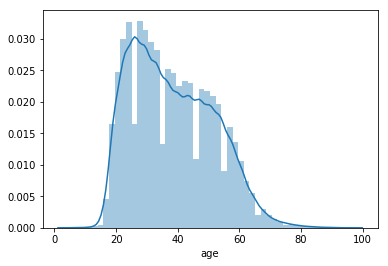

In [10]:
sns.distplot(data.age)
plt.show()

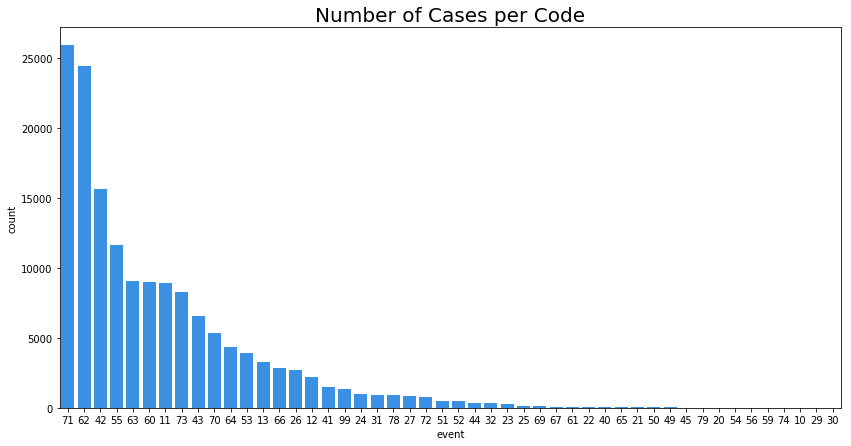

In [11]:
fig = plt.figure(figsize=(14,7))
sns.countplot(data.event, order=data.event.value_counts().index, color='dodgerblue')
plt.title("Number of Cases per Code", fontsize=20)
plt.show()

In [12]:
# Create column to represent major grouping for event

data['event_group'] = [0] * len(data)

data.loc[(data.event<20), 'event_group'] = 'Violence by person or animal'
data.loc[(data.event>=20) & (data.event<30), 'event_group'] = 'Transportation incidents'
data.loc[(data.event>=30) & (data.event<40), 'event_group'] = 'Fires and Explosions'
data.loc[(data.event>=40) & (data.event<50), 'event_group'] = 'Falls, Slips, Trips'
data.loc[(data.event>=50) & (data.event<60), 'event_group'] = 'Exposure to harmful substances or environments'
data.loc[(data.event>=60) & (data.event<70), 'event_group'] = 'Contact with objects and equipment'
data.loc[(data.event>=70) & (data.event<80), 'event_group'] = 'Overexertion and Bodily Reaction'
data.loc[(data.event>=99), 'event_group'] = 'Unclassifiable'

data.head()


,text,sex,age,event,event_group
0,57YOM WITH CONTUSION TO FACE AFTER STRIKING IT...,1,57,62,Contact with objects and equipment
1,A 45YOM FELL ON ARM WHILE WORKING HAD SLIPPED ...,1,45,42,"Falls, Slips, Trips"
2,58YOM WITH CERVICAL STRAIN BACK PAIN S P REST...,1,58,26,Transportation incidents
3,33 YOM LAC TO HAND FROM A RAZOR KNIFE,1,33,60,Contact with objects and equipment
4,53YOM AT WORK IN A WAREHOUSE DOING UNSPECIFIED...,1,53,71,Overexertion and Bodily Reaction


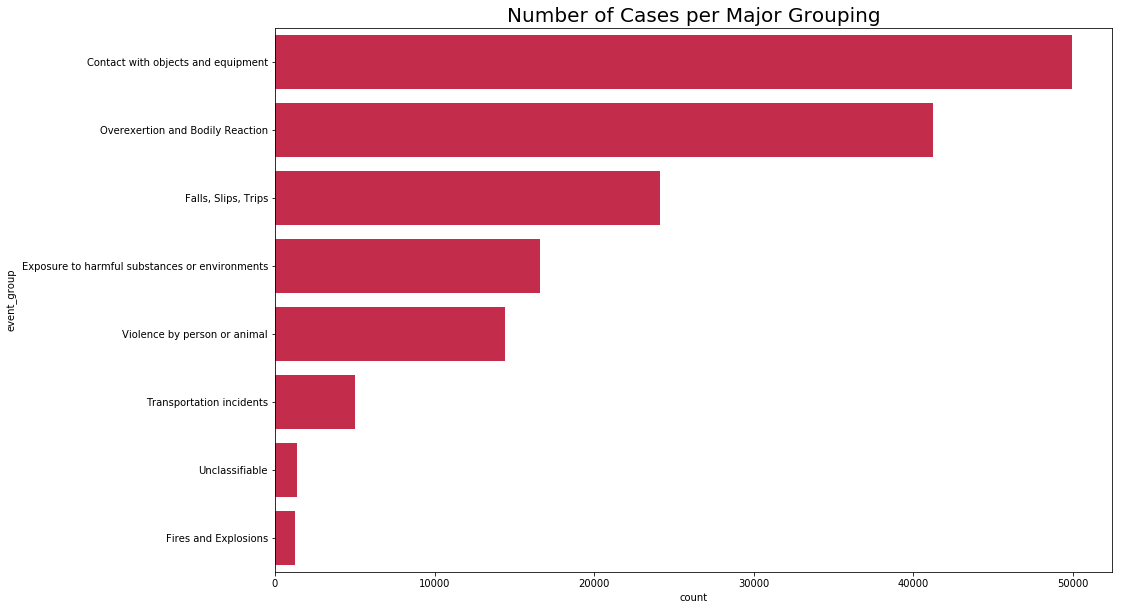

In [13]:
fig = plt.figure(figsize=(15,10))
sns.countplot(y='event_group',
              data=data,
              #orient="h",
              order=data.event_group.value_counts().index, 
              color='crimson')
plt.title("Number of Cases per Major Grouping", fontsize=20)

plt.show()

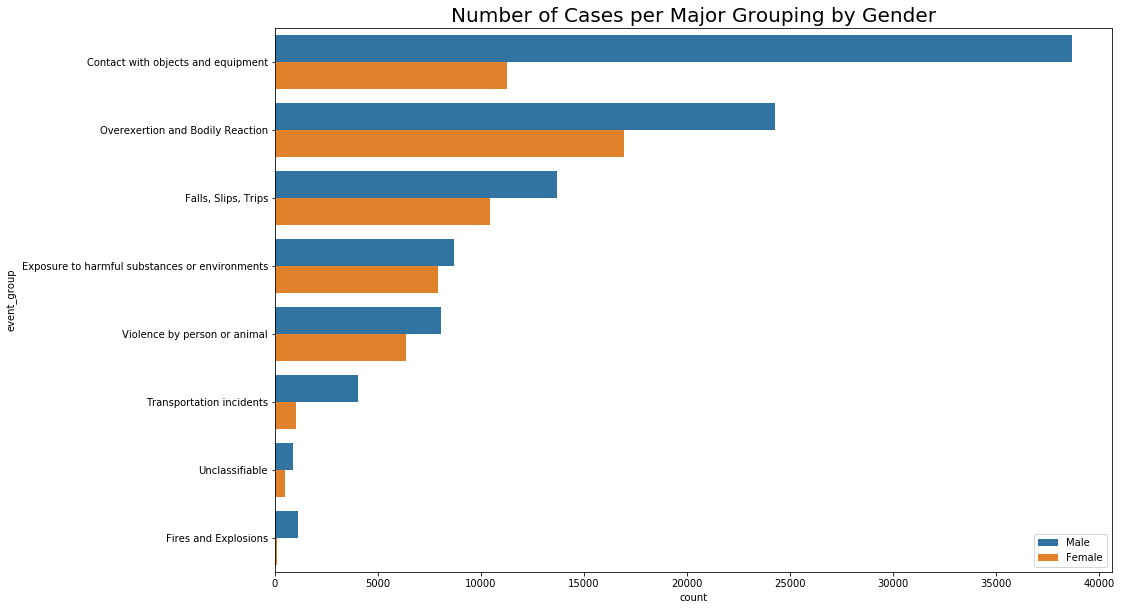

In [14]:
fig = plt.figure(figsize=(15,10))
sns.countplot(y='event_group',
              data=data,
              hue='sex',
              order=data.event_group.value_counts().index, 
              )
plt.legend(['Male', 'Female'])
plt.title("Number of Cases per Major Grouping by Gender", fontsize=20)
plt.show()

In [15]:
# Import word vectors
import spacy

nlp = spacy.load("en_core_web_md")

In [16]:
# Import regex
import re

In [17]:
def get_body_part(txt):
    pattern_head = "(HEAD|NECK|FACE|EYE|NOSE|MOUTH|TEETH|TOOTH|TONGUE|LIP|CHIN|SKULL|EAR|CHEEK)"
#     p_head = re.compile(pattern_head)
#     result_head = p_head.findall(txt)
    
    pattern_arm = "(HAND|FINGER|THUMB|WRIST|ARM|SHOULDER|ELBOW|BICEP|TRICEP|FOREARM)"
#     p_arm = re.compile(pattern_arm)
#     result_arm = p_arm.findall(txt)
    
    pattern_trunk = "(CHEST|BACK|RIB|STOMACH|STERNUM|COLLAR|CLAVICAL|ORGAN|KIDNEY|LIVER|HEART|LUNG|INTESTINE|SPINE)"
#     p_trunk = re.compile(pattern_trunk)
#     result_trunk = p_trunk.findall(txt)
    
    pattern_leg = "(FOOT|FEET|TOE|ANKLE|HEEL|SHIN|KNEE|LEG|THIGH|CALF|CALVES|HIP|BUTTOCK|GLUTE|BUTT|COCCYX|PELVIS|GENITALS|HAMSTRING|QUAD)"
#     p_leg = re.compile(pattern_leg)
#     result_leg = p_leg.findall(txt)
    
    pattern_list = [(pattern_head, 'head/neck'), 
                    (pattern_arm, 'arms'),
                    (pattern_trunk, 'trunk'),
                    (pattern_leg, 'legs')]
    
    result_list = []
    
    
    for i in range(0, len(txt)):
        body_parts = []
        for pattern in pattern_list:
            p = re.compile(pattern[0])
            results = p.findall(txt[i])
            
            if len(results) > 0:
            
                body_parts.append(pattern[1])
                
            else:
                
                pass

        result_list.append((i, body_parts))
            
    return result_list

In [19]:
test = get_body_part(data.text)
print(len(test),len(data.text))

153956 153956


In [20]:
def get_context(txt):
    pattern1 = "(PUNCH|KICK|BITE|SCRATCH|ATTACK|HARM|FIGHT|STAB|SHOOT|INFLICT|ANIMAL|INSECT|VENOM|INTENT)"

    pattern2 = "(AIRCRAFT|VEHICLE|PLANE|CAR|BIKE|CYCLE|ROADWAY|PEDESTRIAN|TRAIN|MOTOR)"

    
    pattern3 = "(FIRE|BOMB|EXPLOSION|EXPLODE|IGNITION|PRESSURE|BLAST)"

    
    pattern4 = "(FALL|SLIP|TRIP|JUMP)"
    
    pattern5 = "(EXPOSURE|SUBSTANCE|CHEMICAL|ENVIRONMENT|RADIATION|EXTREME|EXPOSE|ELECTRIC|TEMPERATURE)"
    
    pattern6 = "(NEEDLE|MACHINE|CONTACT|STRUCK|EQUIP|COLLAPS|CRUSH|FRICTION)"
    
    pattern7 = "(EXERT|BODILY|HEAVY|LIFT|PUSH|OBJECT|REPETITIVE|REPEAT)"
    

    
    pattern_list = [(pattern1, 'violence people/animal'), 
                    (pattern2, 'transportation'),
                    (pattern3, 'fires/explosions'),
                    (pattern4, 'falls/slips/trips'),
                    (pattern5, 'exposure'),
                    (pattern6, 'objects/equipment'),
                    (pattern7, 'overexertion')]
    
    result_list = []
    
    
    for i in range(0, len(txt)):
        groups = []
        for pattern in pattern_list:
            p = re.compile(pattern[0])
            results = p.findall(txt[i])
            
            if len(results) > 0:
            
                groups.append(pattern[1])
                
            else:
                
                pass
        if len(groups) < 1:
            groups.append('None')

        result_list.append((i, groups))
            
    return result_list

In [21]:
test2 = get_context(data.text)
print(len(test2), len(data.text))

153956 153956


In [22]:
print(test2[48])
print(test2[49])
print(test2[50])

(48, ['falls/slips/trips'])
(49, ['falls/slips/trips'])
(50, ['fires/explosions'])


In [17]:
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

from nltk.collocations import *
from nltk import FreqDist
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
import string # to remove punctuation
# from gensim.models import Word2Vec

In [24]:
data.head()

,text,sex,age,event,event_group
0,57YOM WITH CONTUSION TO FACE AFTER STRIKING IT...,1,57,62,Contact with objects and equipment
1,A 45YOM FELL ON ARM WHILE WORKING HAD SLIPPED ...,1,45,42,"Falls, Slips, Trips"
2,58YOM WITH CERVICAL STRAIN BACK PAIN S P REST...,1,58,26,Transportation incidents
3,33 YOM LAC TO HAND FROM A RAZOR KNIFE,1,33,60,Contact with objects and equipment
4,53YOM AT WORK IN A WAREHOUSE DOING UNSPECIFIED...,1,53,71,Overexertion and Bodily Reaction


In [32]:
stopwords_list = stopwords.words('english')
stopwords_list += list(string.punctuation)

def stop_and_tokenize_text (txt):
    
    text = txt.lower()
    
    tokens = word_tokenize(text)
    
    stopped_tokens = [w for w in tokens if w not in stopwords_list]
    
    return stopped_tokens

In [33]:
data['tokenized'] = data.text.apply(stop_and_tokenize_text)
data.head()

,text,sex,age,event,event_group,tokenized
0,57YOM WITH CONTUSION TO FACE AFTER STRIKING IT...,1,57,62,Contact with objects and equipment,"[57yom, contusion, face, striking, post, pound..."
1,A 45YOM FELL ON ARM WHILE WORKING HAD SLIPPED ...,1,45,42,"Falls, Slips, Trips","[45yom, fell, arm, working, slipped, water, fx..."
2,58YOM WITH CERVICAL STRAIN BACK PAIN S P REST...,1,58,26,Transportation incidents,"[58yom, cervical, strain, back, pain, p, restr..."
3,33 YOM LAC TO HAND FROM A RAZOR KNIFE,1,33,60,Contact with objects and equipment,"[33, yom, lac, hand, razor, knife]"
4,53YOM AT WORK IN A WAREHOUSE DOING UNSPECIFIED...,1,53,71,Overexertion and Bodily Reaction,"[53yom, work, warehouse, unspecified, lifting,..."


In [35]:
def create_vector_df(vector_df):
    '''This function converts a dataframe where each instance is the vector for a particular word in the form of a
    list into a dataframe where each column represents a dimension from the vector. The function assumes all vectors
    are the same shape. Designed to be used as a helper function with the get_spacy_vectors function.
    
    vector_df: a column from a pandas dataframe where each row contains a word vector in the form of a python list
    
    returns a pandas dataframe where each column represents one of the dimensions from the vector and each row is 
    an individual vector
    
    '''
    
    # List to hold individual, transposed vectors
    df = []
    # Loop through each instance
    for i in list(range(0,len(vector_df.vector))):
        # Put vector into a dataframe and transpose; (n,1) --> (1,n)
        vectors = pd.DataFrame(vector_df.vector[i]).T
        # Store individual, transposed vector in a list for subsequent concatenation
        df.append(vectors)
    # Combine all individual, transposed vectors into a single dataframe
    vecs_df = pd.concat(df, axis=0)
    
    return vecs_df


def get_spacy_vectors(text):
    '''Function designed to grab the english SpaCy vectors for the words in a specific corpus and return them in a
    dataframe where each row corresponds to a specific vector and where each column represents one of the dimensions 
    of the vector.
    
    text: tokenized string; designed to take in a column from a pandas dataframe with tokenized texts as intances
    
    returns a pandas dataframe where each column represents one of the dimensions from the vector and each row is 
    an individual vector
    
    '''
    # Instantiate a dictionary to hold word vectors
    word_vecs = {}
    
    # Loop through each tokenized document in the input text
    for doc in text:
        # Loop through each token in the text instance
        for word in doc:
            # Conditional to detemine if the text instance word is in SpaCy's embedded vocabulary
            if word in nlp.vocab:
                # Create a word:vector entry in the word_vecs dictionary
                word_vecs[word] = nlp.vocab[word].vector
            # Discard the text instance word if not in SpaCy's embedded vocabulary
            else:
                continue
    # Create a dataframe where each instance holds the word's vector as a list
    vec_df = pd.DataFrame()
    vec_df['vector'] = [word_vecs[x] for x in list(word_vecs.keys())]
    vec_df['word'] = [x for x in list(word_vecs.keys())]
    
    # Use the create_vector_df helper function to convert the vectors stored as lists into their own dataframe
    vectors_df = create_vector_df(vec_df)
    
    return vectors_df

In [127]:
# Sample each of the 8 different major categories of injury claims

def get_vectors_by_group (df, grp_col, n_sample, grp_list, text_col):
    
    grp_vectorized = []
    
    for grp in grp_list:
        grp_df = df[df[grp_col] == grp]
        
        sample = grp_df.sample(n=n_sample, random_state=26)
        
        grp_vecs = get_spacy_vectors(sample[text_col])
        
        grp_vectorized.append((grp, grp_vecs))
        
    return grp_vectorized

In [128]:
groups = ['Contact with objects and equipment', 'Falls, Slips, Trips',
'Transportation incidents', 'Overexertion and Bodily Reaction',
'Exposure to harmful substances or environments',
'Violence by person or animal', 'Unclassifiable',
'Fires and Explosions']

grp_to_vec = get_vectors_by_group(data, 'event_group', 600, groups, 'tokenized')

In [129]:
grp_to_vec[0][1].head()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,-0.002837,0.029502,-0.078415,-0.276090,-0.341390,0.25228,-0.32558,-0.34949,0.135360,2.21870,...,-0.442200,-0.531590,0.299950,0.450870,0.070206,-0.143590,0.571500,-0.27858,-0.108280,0.307910
0,-0.342340,-0.006001,-0.484450,0.035302,-0.097469,0.56999,-0.22360,0.12668,0.376260,0.61294,...,0.358130,-0.315400,-0.511700,-0.153860,0.224350,-0.138290,-0.236050,-0.52713,-0.046381,0.209960
0,0.115570,-0.000923,-0.391370,-0.339040,-0.234380,-0.80601,-0.68909,1.06510,-0.154550,0.74594,...,-0.011675,-0.761930,-0.003082,-0.076599,0.167370,-0.353430,-0.764750,-0.49123,-0.702710,0.228490
0,0.042168,0.336430,-0.290820,-0.214230,-0.402020,0.50948,0.27164,-0.33041,0.156030,0.50138,...,0.201580,-0.484690,0.306240,-0.324850,0.341220,-0.059297,0.068063,-0.15341,-0.540990,0.193950
0,0.054071,0.111100,-0.145570,-0.024294,0.381100,-0.14389,-0.17998,-0.31079,-0.007969,2.65380,...,-0.224790,-0.034352,-0.082647,-0.134850,-0.113710,-0.072454,-0.073029,-0.27098,0.044033,0.003769


In [130]:
def pca_3d(grps_vectors, title, elev=None, rotate=None):
    ''' Function designed to reduce (via PCA) the high-dimensional word vectors to three 
    dimensions with the intention of plotting their relationship. 
    
    grps_vectors: tuple containing the group name and a pandas dataframe containing the word 
    vectors where each row represents and entire vector and each column represents a dimension
    of the vectors >> ex. ('group name', vector_df)
    
    title: string denoting the title of the plot
    
    elev: integer pertaining to what elevation to apply to the view of the 3d plot
    
    rotate: integer pertaining to what angle to apply to the view of the 3d plot
    
    returns a three dimensional plot at the specified viewing angle
    
    '''
    fig = plt.figure(figsize=(15,10))
    ax = fig.add_subplot(111, projection='3d')
    
    pca = PCA(n_components=3)
    
    for i in range(0,len(grps_vectors)):
        vec_df = grps_vectors[i][1]
        pca_vec = pca.fit_transform(vec_df)
        results = pd.DataFrame(data=pca_vec, columns=['pc1', 'pc2', 'pc3'])
        ax.scatter(results['pc1'],
                   results['pc2'],
                   results['pc3'],
                   alpha=0.3,
                   label=grps_vectors[i][0])
        
    ax.set_title(title)
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')
    ax.view_init(elev, rotate)
    plt.legend()
    plt.show()


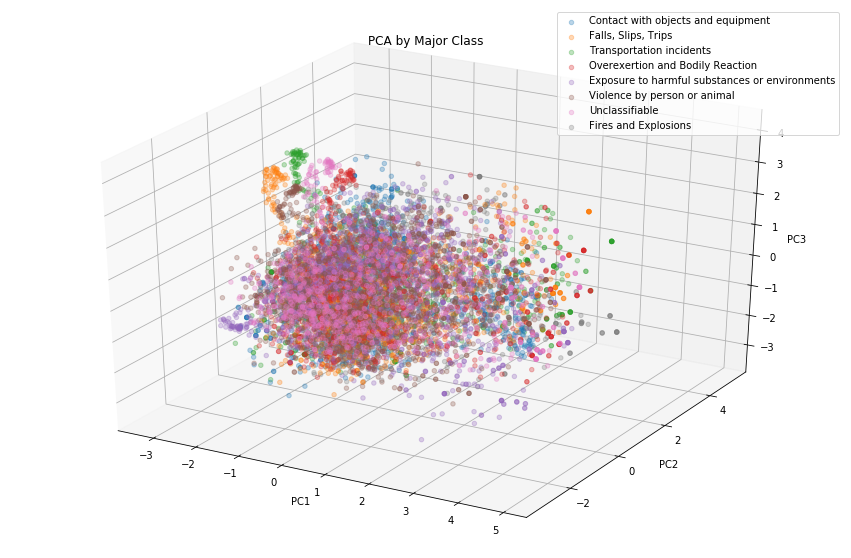

In [140]:
pca_3d(grp_to_vec, 'PCA by Major Class')

In [ ]:
def get_freq_dist_by_group (df, grp_col, top_n, grp_list, text_col):
    
    grp_freq = []
    
    for grp in grp_list:
    
        grp_df = df[df[grp_col] == grp] # change to grp if going back to loop

        all_tokens = []

        for i in grp_df[text_col]:
            for t in i:
                all_tokens.append(t)

        freqdist = FreqDist(all_tokens)

        most_common = freqdist.most_common(top_n)

    #     freq_df = pd.DataFrame(columns=['group', 'most_common'])

    #     words_common = []
    #     for n in most_common:
    #         words_common.append(n[0])


    #     freq_df['group'] = grp # change to grp if going back to loop
    #     freq_df['most_common'] = list(words_common)



        grp_freq.append((grp, most_common))
        
    return grp_freq

In [ ]:
grp_freq = get_freq_dist_by_group(data, 'event_group', 20, groups, 'tokenized')

In [203]:
i = 4

print(f"Displaying Frequency Distribution for {grp_freq[i][0]}:")
print("")
grp_freq[i][1]

Displaying Frequency Distribution for Exposure to harmful substances or environments:



[('work', 8891),
 ('dx', 8192),
 ('needle', 5105),
 ('finger', 4820),
 ('burn', 3054),
 ('exposure', 2860),
 ('stuck', 2751),
 ('w', 2692),
 ('eye', 2455),
 ('hand', 2243),
 ('pt', 2238),
 ('c', 2150),
 ('yom', 2059),
 ('stick', 1938),
 ('yof', 1882),
 ('working', 1839),
 ('hot', 1765),
 ('got', 1746),
 ('chemical', 1705),
 ('heat', 1580)]

# Modeling

In [18]:
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, LSTM, GRU, Embedding
from keras.layers import Dropout, Activation, Bidirectional, GlobalMaxPool1D
from keras.models import Model, Sequential
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.preprocessing import text, sequence
from sklearn.metrics import confusion_matrix

Using TensorFlow backend.


In [45]:
# Model Evaluation
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import itertools

In [23]:
def preprocess (data_df, fraction, stop=False, max_seq_len=1000):
    '''Process data for kera text classification. Takes in a dataframe containing raw text and their corresponding
    labels. Returns a tokenized and padded sequences for training and test sets, along with their one-hot encoded
    labels. The function also returns the labels prior to one-hot encoding for the sole purpose of checking class
    counts.
    
    data_df: pandas dataframe containing the raw texts and labels
    
    fraction: float between 0 and 1 pertaining to the percentage of the data_df to sample and preprocess
    
    stop: boolean to include stopwords in filter; default == False
    
    max_seq_len: integer specifying the maximum length of the tokenized sequences during padding; default == 1000
    
    returns tokenized and padded sequences for training and test sets, along with one-hot encoded labels in the order
    of train_x, test_x, train_y_keras, test_y_keras, train_Y, test_Y
    
    '''
    # Sample the data according to specified percentage
    data_sample = data_df.sample(frac=fraction, random_state=16)
    
    # Split the data into a training and test set
    train_X, test_X, train_Y, test_Y = train_test_split(data_sample.text, data_sample.event_group, test_size=0.2,
                                                       random_state=16)
    
    ## Convert labels to dummie values (formatting for keras model use of categorical_crossentropy)
    train_y_keras = pd.get_dummies(train_Y)
    test_y_keras = pd.get_dummies(test_Y)
    
    # Conditional to deal with if the data should have stopwords removed
    if stop == True:
        # Get a list of training instances
        list_train_texts = train_X.values
        # Instantiate a tokenizer to convert words to tokens, filter out stopwords, and lowercase all tokens
        tokenizer = text.Tokenizer(num_words=26000, lower=True, filters=joined_stop)
        # Fit the tokenizer to the training data
        tokenizer.fit_on_texts(list(list_train_texts))
        # Convert the tokenized words to a sequence (for recurrent/bidirectional modeling)
        list_tokenized_train = tokenizer.texts_to_sequences(list_train_texts)
        # Get a list of testing instances
        list_test_texts = test_X.values
        # Fit the tokenizer on the testing data
        tokenizer.fit_on_texts(list(list_test_texts))
        # Convert the tokenized words to a sequence (for recurrent/bidirectional modeling)
        list_tokenized_test = tokenizer.texts_to_sequences(list_test_texts)
        
        # Pad the tokenized sequences to the specified length
        train_x_tokenized = sequence.pad_sequences(list_tokenized_train, maxlen=max_seq_len)
        test_x_tokenized = sequence.pad_sequences(list_tokenized_test, maxlen=max_seq_len)
        
    # Conditional to deal with if the data should not have stopwords removed
    else:
        # Get a list of training instances
        list_train_texts = train_X.values
        # Instantiate a tokenizer to convert words to tokens and lowercase all tokens
        tokenizer = text.Tokenizer(num_words=26000, lower=True)
        # Fit the tokenizer to the training data
        tokenizer.fit_on_texts(list(list_train_texts))
        # Convert the tokenized words to a sequence (for recurrent/bidirectional modeling)
        list_tokenized_train = tokenizer.texts_to_sequences(list_train_texts)
        # Get a list of testing instances
        list_test_texts = test_X.values
        # Fit the tokenizer on the testing data
        tokenizer.fit_on_texts(list(list_test_texts))
        # Convert the tokenized words to a sequence (for recurrent/bidirectional modeling)
        list_tokenized_test = tokenizer.texts_to_sequences(list_test_texts)
        
        # Pad the tokenized sequences to the specified length
        train_x_tokenized = sequence.pad_sequences(list_tokenized_train, maxlen=max_seq_len)
        test_x_tokenized = sequence.pad_sequences(list_tokenized_test, maxlen=max_seq_len)
    
    return train_x_tokenized, test_x_tokenized, train_y_keras, test_y_keras, train_Y, test_Y

In [20]:
# Create a list of nltk stopwords
stopwords_list = stopwords.words('english')

# Add all punctuation to the stopwords list
stopwords_list += list(string.punctuation)

# Add common words/abbreviations from EDA to stop words
stopwords_list += ['dx', 'work', 'pt']

# Create single string of all stopwords to pass a filter with keras tokenizer
joined_stop = ''.join(tok for tok in stopwords_list)

In [21]:
data.head()

,text,sex,age,event,event_group
0,57YOM WITH CONTUSION TO FACE AFTER STRIKING IT...,1,57,62,Contact with objects and equipment
1,A 45YOM FELL ON ARM WHILE WORKING HAD SLIPPED ...,1,45,42,"Falls, Slips, Trips"
2,58YOM WITH CERVICAL STRAIN BACK PAIN S P REST...,1,58,26,Transportation incidents
3,33 YOM LAC TO HAND FROM A RAZOR KNIFE,1,33,60,Contact with objects and equipment
4,53YOM AT WORK IN A WAREHOUSE DOING UNSPECIFIED...,1,53,71,Overexertion and Bodily Reaction


In [25]:
lengths = []
for txt in data.text:
    lengths.append(len(txt))
    
np.mean(lengths)

86.94918028527631

In [38]:
train_x, test_x, train_y_keras, test_y_keras, train_Y, test_Y = preprocess(data, 0.75, True, 90)

In [47]:
train_Y.value_counts()

Contact with objects and equipment                29962
Overexertion and Bodily Reaction                  24627
Falls, Slips, Trips                               14447
Exposure to harmful substances or environments     9904
Violence by person or animal                       8782
Transportation incidents                           3059
Unclassifiable                                      820
Fires and Explosions                                772
Name: event_group, dtype: int64

In [40]:
# Create a baseline model
baseline = Sequential()
baseline.add(Embedding(26000, 200))
baseline.add(Bidirectional(GRU(32, return_sequences=True)))
baseline.add(GlobalMaxPool1D())
baseline.add(Dense(80, activation='relu'))
baseline.add(Dropout(0.2))
baseline.add(Dense(40, activation='relu'))
baseline.add(Dropout(0.2))
baseline.add(Dense(8, activation='softmax'))

# Assemble the baseline model
baseline.compile(loss='categorical_crossentropy',
                optimizer='adadelta',
                metrics=['accuracy'])

# Fit the model to the training data
history_baseline = baseline.fit(train_x, train_y_keras, epochs=5, batch_size=32, validation_split=0.15)

Train on 78517 samples, validate on 13856 samples
Epoch 1/5
78517/78517 [==============================] - 261s 3ms/step - loss: 1.6652 - acc: 0.3246 - val_loss: 1.6487 - val_acc: 0.3284
Epoch 2/5
78517/78517 [==============================] - 260s 3ms/step - loss: 1.6425 - acc: 0.3327 - val_loss: 1.6464 - val_acc: 0.3354
Epoch 3/5
78517/78517 [==============================] - 262s 3ms/step - loss: 1.6380 - acc: 0.3369 - val_loss: 1.6439 - val_acc: 0.3278
Epoch 4/5
78517/78517 [==============================] - 264s 3ms/step - loss: 1.6361 - acc: 0.3385 - val_loss: 1.6443 - val_acc: 0.3266
Epoch 5/5
78517/78517 [==============================] - 268s 3ms/step - loss: 1.6340 - acc: 0.3393 - val_loss: 1.6434 - val_acc: 0.3318


In [41]:
def model_performance(model_history):
    '''Create two subplots to display the loss and accuracy changes during model training for both the training and
    validation sets.
    
    model_history: keras model.fit object storing the model performance metrics across training epochs
    
    returns two subplots displaying the loss and accuracy of the model across training epochs for both the training
    and validation sets. Training values are displayed in red and validation values are displayed in blue.
    '''
    # Create a variable to work with the model history
    history_dict = model_history.history
    # Isolate the model's loss measures over the course of training
    loss_values = history_dict['loss']
    # Isolate the model's loss measures over the course of validation
    val_loss_values = history_dict['val_loss']
    
    # Variable to set the plot's X values
    epochs = range(1, len(loss_values) + 1)
    
    # Instantiate the subplots
    fig, ax = plt.subplots(1, 2, figsize=[25,10])
    
    # Format the training/validation loss plot
    ax[0].plot(epochs, loss_values, 'red', label='Training loss')
    ax[0].plot(epochs, val_loss_values, 'blue', label='Validation loss')
    ax[0].set_title('Training and Validation loss', fontsize=20)
    ax[0].set_xlabel('Epochs', fontsize=16)
    ax[0].set_ylabel('Loss', fontsize=16)
    ax[0].legend()
    
    
    # Isolate the model's accuracy measures over the course of training
    acc_values = history_dict['acc']
    # Isolate the model's accuracy measures over the course of validation
    val_acc_values = history_dict['val_acc'] 
    
    # Format the training/validation accuracy plot
    ax[1].plot(epochs, acc_values, 'red', label='Training acc')
    ax[1].plot(epochs, val_acc_values, 'blue', label='Validation acc')
    ax[1].set_title('Training and Validation accuracy', fontsize=20)
    ax[1].set_xlabel('Epochs', fontsize=16)
    ax[1].set_ylabel('Accuracy', fontsize=16)

    plt.legend()

    plt.show()

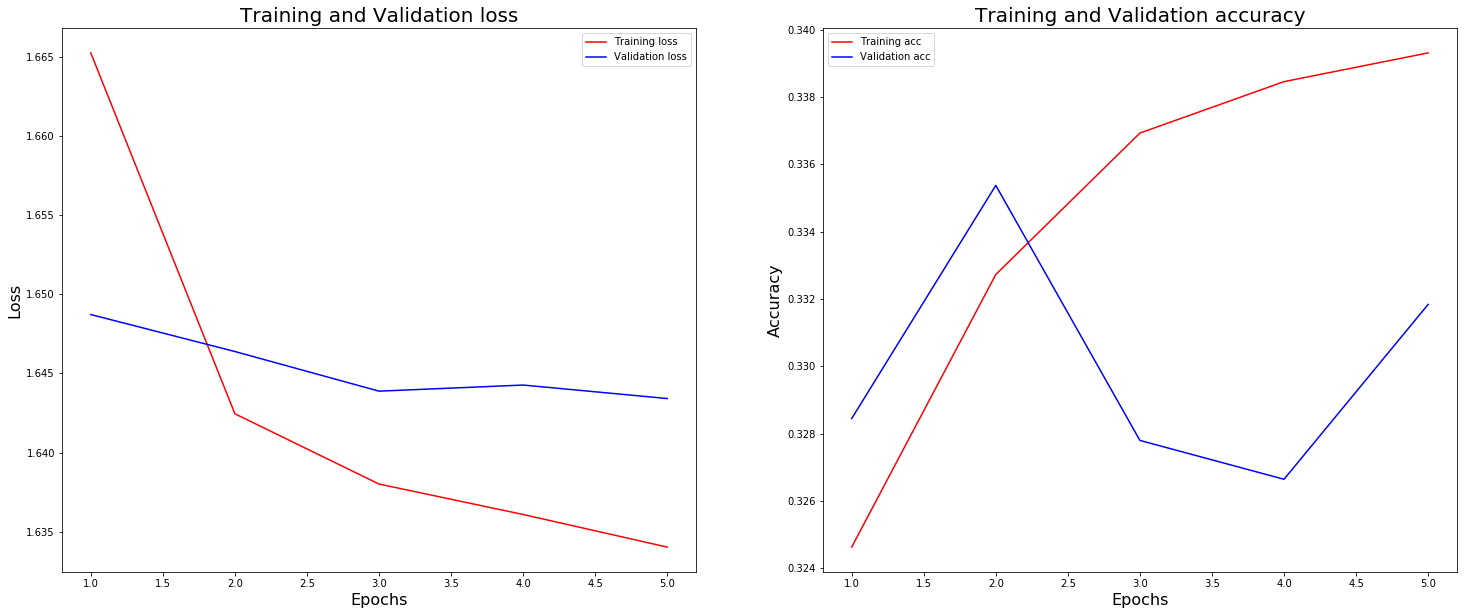

In [42]:
model_performance(history_baseline)

In [63]:
#cnf_matrix = confusion_matrix(y_hat_test, y_test)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Purples):
    
    '''Create a confusion matrix to visualize model performance on testing data.
    
    cm: an SKLearn confusion matrix
    classes: list of class names to use as x and y tick labels; list of strings
    normalize: boolean to normalize values (integers for count --> percentage)
    cmap: matplotlib color map to use for plot
    
    returns a matplotlib plot of a confusion matrix
    
    '''
    #Add Normalization Option
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    # Create/format confusion matrix plot
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [49]:
test_Y.unique()

array(['Overexertion and Bodily Reaction', 'Falls, Slips, Trips',
       'Contact with objects and equipment',
       'Exposure to harmful substances or environments',
       'Transportation incidents', 'Violence by person or animal',
       'Fires and Explosions', 'Unclassifiable'], dtype=object)

In [50]:
test_Y.value_counts()

Contact with objects and equipment                7497
Overexertion and Bodily Reaction                  6207
Falls, Slips, Trips                               3626
Exposure to harmful substances or environments    2495
Violence by person or animal                      2107
Transportation incidents                           773
Unclassifiable                                     204
Fires and Explosions                               185
Name: event_group, dtype: int64

In [51]:
# Evaluate results in a classification report/confusion matrix

# Generate predictions for the test set
baseline_preds_test = baseline.predict(test_x)

print(classification_report(test_y_keras.values.argmax(axis=1), 
                            baseline_preds_test.argmax(axis=1),
                           target_names=['Contact with objects/equipment', 
                                         'Exposure to harmful substance/environment',
                                        'Falls, Slips, Trips', 'Fires/Explosions',
                                        'Overexertion', 'Transportation Incidents',
                                        'Unclassifiable', 'Violence by Person/Animal']))

                                           precision    recall  f1-score   support

           Contact with objects/equipment       0.33      0.83      0.47      7497
Exposure to harmful substance/environment       0.41      0.03      0.05      2495
                      Falls, Slips, Trips       0.29      0.08      0.13      3626
                         Fires/Explosions       0.00      0.00      0.00       185
                             Overexertion       0.34      0.17      0.23      6207
                 Transportation Incidents       0.00      0.00      0.00       773
                           Unclassifiable       0.00      0.00      0.00       204
                Violence by Person/Animal       0.00      0.00      0.00      2107

                                micro avg       0.33      0.33      0.33     23094
                                macro avg       0.17      0.14      0.11     23094
                             weighted avg       0.29      0.33      0.24     23094



/Users/kpokrass_pro/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kpokrass_pro/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kpokrass_pro/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Confusion matrix, without normalization


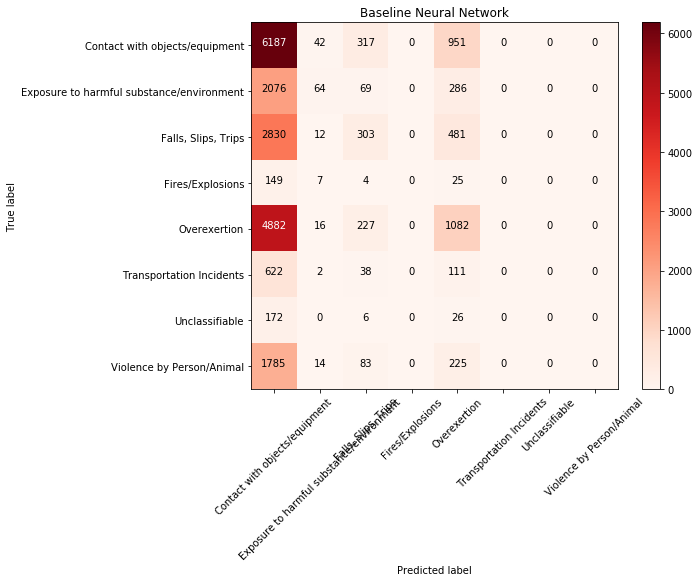

In [53]:
baseline_cm_keras = confusion_matrix(test_y_keras.values.argmax(axis=1), baseline_preds_test.argmax(axis=1))
fig = plt.figure(figsize=[10,8])
plot_confusion_matrix(baseline_cm_keras, ['Contact with objects/equipment', 
                                         'Exposure to harmful substance/environment',
                                        'Falls, Slips, Trips', 'Fires/Explosions',
                                        'Overexertion', 'Transportation Incidents',
                                        'Unclassifiable', 'Violence by Person/Animal'], 
                      cmap= plt.cm.Reds,
                      title='Baseline Neural Network')

In [54]:
def preprocess_imbalance (data_df, num_obvs, stop=False, max_seq_len=1000):
    '''Process data for kera text classification. Takes in a dataframe containing raw text and their corresponding
    labels. Returns a tokenized and padded sequences for training and test sets, along with their one-hot encoded
    labels. The function also returns the labels prior to one-hot encoding for the sole purpose of checking class
    counts.
    
    data_df: pandas dataframe containing the raw texts and labels
    
    fraction: float between 0 and 1 pertaining to the percentage of the data_df to sample and preprocess
    
    stop: boolean to include stopwords in filter; default == False
    
    max_seq_len: integer specifying the maximum length of the tokenized sequences during padding; default == 1000
    
    returns tokenized and padded sequences for training and test sets, along with one-hot encoded labels in the order
    of train_x, test_x, train_y_keras, test_y_keras, train_Y, test_Y
    
    '''
    df1 = data_df[data_df['event_group'] == 'Contact with objects and equipment']
    df2 = data_df[data_df['event_group'] == 'Overexertion and Bodily Reaction']
    df3 = data_df[data_df['event_group'] == 'Falls, Slips, Trips']
    df4 = data_df[data_df['event_group'] == 'Exposure to harmful substances or environments']
    df5 = data_df[data_df['event_group'] == 'Violence by person or animal']
    df6 = data_df[data_df['event_group'] == 'Transportation incidents']
    df7 = data_df[data_df['event_group'] == 'Fires and Explosions']
    df8 = data_df[data_df['event_group'] == 'Unclassifiable']
    
    
    
    # Sample the data according to specified number
    sample1 = df1.sample(n=num_obvs, random_state=16)
    sample2 = df2.sample(n=num_obvs, random_state=16)
    sample3 = df3.sample(n=num_obvs, random_state=16)
    sample4 = df4.sample(n=num_obvs, random_state=16)
    sample5 = df5.sample(n=num_obvs, random_state=16)
    sample6 = df6.sample(n=num_obvs, random_state=16)
    sample7 = df7.sample(n=num_obvs, random_state=16)
    sample8 = df8.sample(n=num_obvs, random_state=16)
    
    
    # Combine the class samples into one df
    data_sample = pd.concat([sample1, sample2, sample3, sample4, sample5, sample6,
                            sample7, sample8], axis=0)
    
    # Split the data into a training and test set
    train_X, test_X, train_Y, test_Y = train_test_split(data_sample.text, data_sample.event_group, test_size=0.2,
                                                       random_state=16)
    
    ## Convert labels to dummie values (formatting for keras model use of categorical_crossentropy)
    train_y_keras = pd.get_dummies(train_Y)
    test_y_keras = pd.get_dummies(test_Y)
    
    # Conditional to deal with if the data should have stopwords removed
    if stop == True:
        # Get a list of training instances
        list_train_texts = train_X.values
        # Instantiate a tokenizer to convert words to tokens, filter out stopwords, and lowercase all tokens
        tokenizer = text.Tokenizer(num_words=26000, lower=True, filters=joined_stop)
        # Fit the tokenizer to the training data
        tokenizer.fit_on_texts(list(list_train_texts))
        # Convert the tokenized words to a sequence (for recurrent/bidirectional modeling)
        list_tokenized_train = tokenizer.texts_to_sequences(list_train_texts)
        # Get a list of testing instances
        list_test_texts = test_X.values
        # Fit the tokenizer on the testing data
        tokenizer.fit_on_texts(list(list_test_texts))
        # Convert the tokenized words to a sequence (for recurrent/bidirectional modeling)
        list_tokenized_test = tokenizer.texts_to_sequences(list_test_texts)
        
        # Pad the tokenized sequences to the specified length
        train_x_tokenized = sequence.pad_sequences(list_tokenized_train, maxlen=max_seq_len)
        test_x_tokenized = sequence.pad_sequences(list_tokenized_test, maxlen=max_seq_len)
        
    # Conditional to deal with if the data should not have stopwords removed
    else:
        # Get a list of training instances
        list_train_texts = train_X.values
        # Instantiate a tokenizer to convert words to tokens and lowercase all tokens
        tokenizer = text.Tokenizer(num_words=26000, lower=True)
        # Fit the tokenizer to the training data
        tokenizer.fit_on_texts(list(list_train_texts))
        # Convert the tokenized words to a sequence (for recurrent/bidirectional modeling)
        list_tokenized_train = tokenizer.texts_to_sequences(list_train_texts)
        # Get a list of testing instances
        list_test_texts = test_X.values
        # Fit the tokenizer on the testing data
        tokenizer.fit_on_texts(list(list_test_texts))
        # Convert the tokenized words to a sequence (for recurrent/bidirectional modeling)
        list_tokenized_test = tokenizer.texts_to_sequences(list_test_texts)
        
        # Pad the tokenized sequences to the specified length
        train_x_tokenized = sequence.pad_sequences(list_tokenized_train, maxlen=max_seq_len)
        test_x_tokenized = sequence.pad_sequences(list_tokenized_test, maxlen=max_seq_len)
    
    return train_x_tokenized, test_x_tokenized, train_y_keras, test_y_keras, train_Y, test_Y

In [55]:
data.event_group.value_counts()

Contact with objects and equipment                49952
Overexertion and Bodily Reaction                  41207
Falls, Slips, Trips                               24147
Exposure to harmful substances or environments    16585
Violence by person or animal                      14429
Transportation incidents                           5030
Unclassifiable                                     1373
Fires and Explosions                               1233
Name: event_group, dtype: int64

In [56]:
train_x, test_x, train_y_keras, test_y_keras, train_Y, test_Y = preprocess_imbalance(data, 1000, 
                                                                                     True, 80)

In [65]:
# Create a baseline model for balanced sample
baseline2 = Sequential()
baseline2.add(Embedding(26000, 200))
baseline2.add(Bidirectional(GRU(32, return_sequences=True)))
baseline2.add(GlobalMaxPool1D())
baseline2.add(Dense(80, activation='relu'))
baseline2.add(Dropout(0.2))
baseline2.add(Dense(40, activation='relu'))
baseline2.add(Dropout(0.2))
baseline2.add(Dense(8, activation='softmax'))

# Assemble the baseline model
baseline2.compile(loss='categorical_crossentropy',
                optimizer='adadelta',
                metrics=['accuracy'])

# Fit the model to the training data
history_baseline2 = baseline2.fit(train_x, train_y_keras, epochs=10, batch_size=32, validation_split=0.15)

Train on 5440 samples, validate on 960 samples
Epoch 1/10
5440/5440 [==============================] - 19s 4ms/step - loss: 2.0807 - acc: 0.1294 - val_loss: 2.0790 - val_acc: 0.1250
Epoch 2/10
5440/5440 [==============================] - 18s 3ms/step - loss: 2.0790 - acc: 0.1393 - val_loss: 2.0836 - val_acc: 0.1250
Epoch 3/10
5440/5440 [==============================] - 18s 3ms/step - loss: 2.0709 - acc: 0.1500 - val_loss: 2.0705 - val_acc: 0.1479
Epoch 4/10
5440/5440 [==============================] - 18s 3ms/step - loss: 2.0611 - acc: 0.1732 - val_loss: 2.0675 - val_acc: 0.1719
Epoch 5/10
5440/5440 [==============================] - 18s 3ms/step - loss: 2.0548 - acc: 0.1824 - val_loss: 2.0657 - val_acc: 0.1469
Epoch 6/10
5440/5440 [==============================] - 18s 3ms/step - loss: 2.0474 - acc: 0.1757 - val_loss: 2.0652 - val_acc: 0.1604
Epoch 7/10
5440/5440 [==============================] - 18s 3ms/step - loss: 2.0439 - acc: 0.1827 - val_loss: 2.0623 - val_acc: 0.1573
Epoch 8/

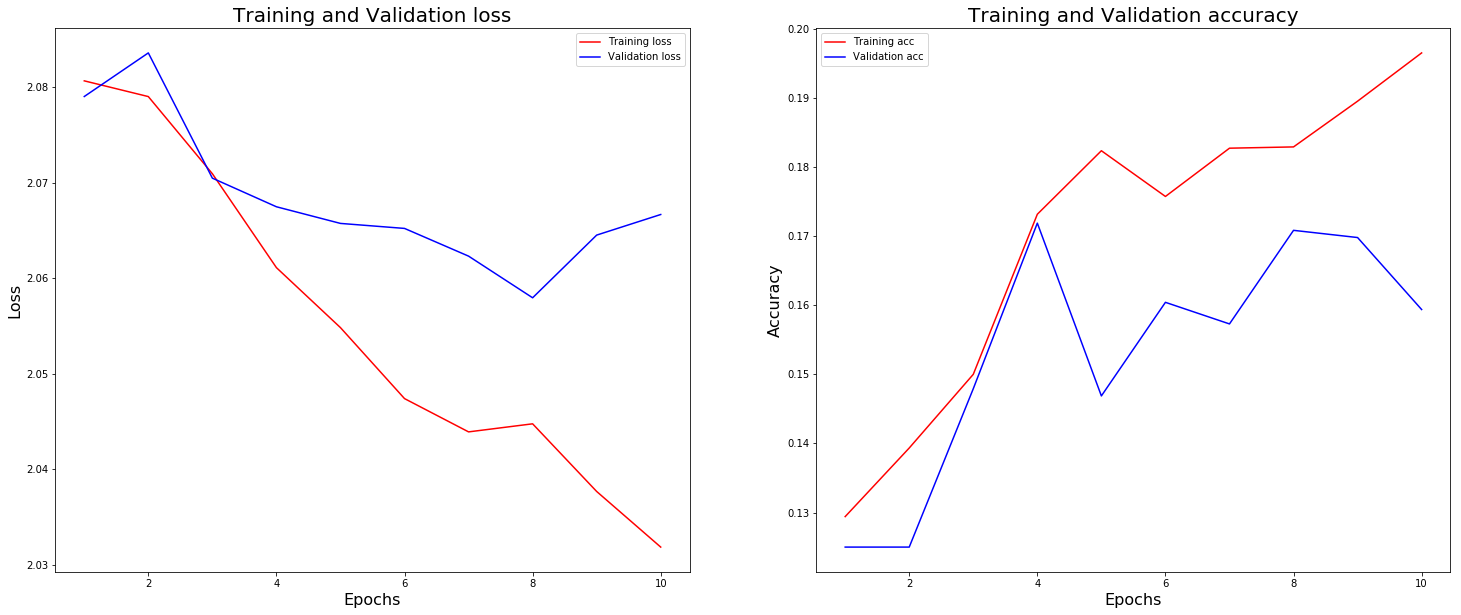

In [66]:
model_performance(history_baseline2)

In [69]:
display(test_Y.value_counts())
test_Y.unique()


Contact with objects and equipment                212
Overexertion and Bodily Reaction                  211
Unclassifiable                                    208
Exposure to harmful substances or environments    206
Violence by person or animal                      201
Fires and Explosions                              196
Transportation incidents                          188
Falls, Slips, Trips                               178
Name: event_group, dtype: int64

array(['Overexertion and Bodily Reaction', 'Unclassifiable',
       'Violence by person or animal', 'Transportation incidents',
       'Falls, Slips, Trips', 'Contact with objects and equipment',
       'Exposure to harmful substances or environments',
       'Fires and Explosions'], dtype=object)

In [67]:
# Evaluate results in a classification report/confusion matrix

# Generate predictions for the test set
baseline_preds_test2 = baseline2.predict(test_x)

print(classification_report(test_y_keras.values.argmax(axis=1), 
                            baseline_preds_test2.argmax(axis=1),
                           target_names=['Contact with objects/equipment', 
                                         'Exposure to harmful substance/environment',
                                        'Falls, Slips, Trips', 'Fires/Explosions',
                                        'Overexertion', 'Transportation Incidents',
                                        'Unclassifiable', 'Violence by Person/Animal']))

                                           precision    recall  f1-score   support

           Contact with objects/equipment       0.00      0.00      0.00       212
Exposure to harmful substance/environment       0.31      0.07      0.11       206
                      Falls, Slips, Trips       0.14      0.42      0.21       178
                         Fires/Explosions       0.15      0.25      0.19       196
                             Overexertion       0.14      0.03      0.05       211
                 Transportation Incidents       0.06      0.02      0.03       188
                           Unclassifiable       0.14      0.28      0.19       208
                Violence by Person/Animal       0.18      0.17      0.18       201

                                micro avg       0.15      0.15      0.15      1600
                                macro avg       0.14      0.16      0.12      1600
                             weighted avg       0.14      0.15      0.12      1600



Confusion matrix, without normalization


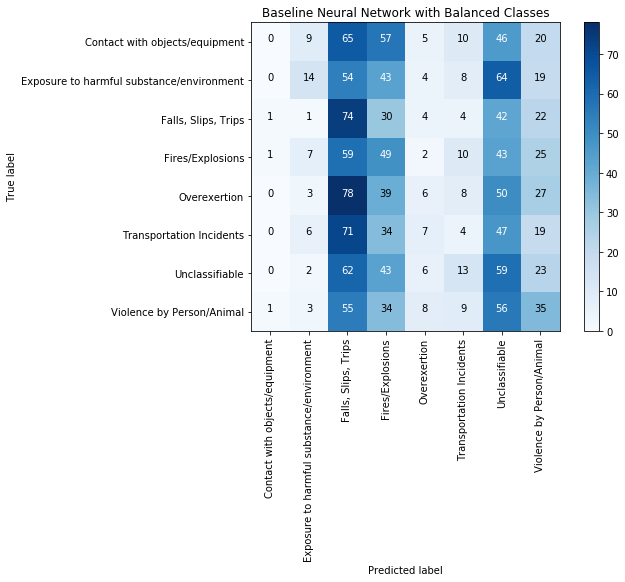

In [68]:
baseline2_cm_keras = confusion_matrix(test_y_keras.values.argmax(axis=1), 
                                      baseline_preds_test2.argmax(axis=1))
fig = plt.figure(figsize=[10,8])
plot_confusion_matrix(baseline2_cm_keras, ['Contact with objects/equipment', 
                                         'Exposure to harmful substance/environment',
                                        'Falls, Slips, Trips', 'Fires/Explosions',
                                        'Overexertion', 'Transportation Incidents',
                                        'Unclassifiable', 'Violence by Person/Animal'], 
                      cmap= plt.cm.Blues,
                      title='Baseline Neural Network with Balanced Classes')